# PAT hyperspectral data inference

Corresponding to the PAT contents in Fig. 2 and Table 1. Tested on a cluster with 32GB memory and a Tesla V100S GPU.

Note that the network inferencing part took 15 minutes during the test, due to the severe sample expansion when combining the channels. 

In [1]:
import os
import itertools
import json

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io as sio 
from scipy.special import comb as sp_comb
from skimage.io import imread
from skimage.util import img_as_float, img_as_ubyte
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

from models import PAT
from ext_utils import move_pixel_value, _project_mesh_grid_to_indices_cube

In [2]:
# characteristics of PAT training data
RGBW_MEAN = np.array([0.5, 0.5, 0.5, 0.5]) - 0.2
RGBW_STD = np.array([0.257, 0.257, 0.257, 0.242])

def img2h9l(img, lr_dim=64, N=9):
    """
    img should be a 256x256 28-channel hyper-spectrum image
    return one-channel tim (total intensity measurement)
       and (lr_dim, lr_dim, N) lrcm (lr channel measurement)
       and (256, 256, N) gt (ground truth)
    The channel orders are swaped, as I prefer RGB input
    """
    # convert 28 channel input image to N channel image
    assert img.shape==(256, 256, 28)
    mc = 28//N
    img_slice = np.reshape(img[...,:N*mc], (256, 256, N, mc)) 
    gt = np.mean(img_slice, axis=3)    
    
    # total intensity measurement
    tim_dim = np.floor(np.sqrt(256**2 - N*(lr_dim**2))).astype(int)
    tim_full = np.sum(gt.copy(), 2)
    tim = cv.resize(tim_full, (tim_dim,tim_dim), interpolation=cv.INTER_AREA)
    
    # low-res channel measurements
    lrcm = [cv.resize(img, (lr_dim,lr_dim), interpolation=cv.INTER_AREA) \
                for img in gt.transpose(2, 0, 1)]
    lrcm = np.stack(lrcm, axis=-1)
    return tim, lrcm, gt

def tim_and_lrcm_to_dual_img(tim, lrcm, comb_code, *, 
                             target_wh=None, rgbw_mean=RGBW_MEAN, rgbw_std=RGBW_STD):
    """
    comb code should be a 3x3 int array, containing 0-8. 
    Each row denotes a combination (sum) of channels. 
    3 rows corresponding to 3 channels in RGB image
    """
    # load and validate parameters
    h, w = tim.shape
    hp, wp, N = lrcm.shape
    assert len(comb_code.shape)==2
    assert comb_code.shape[0]==3
    assert comb_code.size==N
    
    # shuffle and combine lrcs channels
    gray = tim.copy()
    rgb = [lrcm[...,cidx].sum(axis=-1) for cidx in comb_code]
    
    # record mean/std of channels
    cmean_list = np.mean(rgb, axis=(1,2))
    cstd_list = np.std(rgb, axis=(1,2))

    # make rgbw normalize images form list
    rgbw = []
    for img, mean, std in zip((rgb[0], rgb[1], rgb[2], gray), 
                              rgbw_mean, rgbw_std):
        rgbw.append(move_pixel_value(img, mean, std))
    img0 = rgbw[3][..., np.newaxis].repeat(3, axis=2)
    img1 = np.stack(rgbw[:3], axis=-1)
    
    # rescale images
    if target_wh is not None:
        img0 = cv.resize(img0, target_wh, interpolation=cv.INTER_CUBIC)
        img1 = cv.resize(img1, target_wh, interpolation=cv.INTER_CUBIC)

    return img0, img1, cmean_list, cstd_list

def go_through_net(net, img0_list, img1_list, Po, device='cuda'):
    """
    Send a set of image pairs through the network as a batch
    pixel correspondence are generated 
    """
    # parameters
    bs, h, w, c = img0_list.shape
    bsp, hp, wp, cp = img1_list.shape
    assert bs==bsp
    assert c==cp and c==3    
    
    # turn to tensor
    x_left = torch.from_numpy(img0_list.transpose((0, 3, 1, 2))).to(device)
    x_right = torch.from_numpy(img1_list.transpose((0, 3, 1, 2))).to(device)
    
    # send through network
    with torch.no_grad():
        x_left = net.module.init_feature(x_left)
        x_right = net.module.init_feature(x_right)
        buffer_left = net.module.pam.rb(x_left)
        buffer_right = net.module.pam.rb(x_right)
        Q = net.module.pam.b1(buffer_left)
        K = net.module.pam.b2s[0](buffer_right)
        V = net.module.pam.b3s[0](buffer_right)

        buffer_out, _ = net.module.pam.fe_pam(Q, K, V, Po, False)
        fused_feature = torch.cat((buffer_out, x_left), 1)
        out = net.module.pam.fusion(fused_feature)
        out = net.module.upscale(out)
        
    # back to numpy
    out_img = out.cpu().numpy().transpose(0, 2, 3, 1)
    
    # clean and return
    return out_img

In [3]:
# prepare data

# dimension choice
full_dim = 256
lr_dim = 64
hr_dim = np.floor(np.sqrt(full_dim**2 - 9*lr_dim**2)).astype(int)
print("The ground truth image          dimensions are ({}, {}, {})".format(full_dim, full_dim, 9))
print("The total intensity measurement dimensions are ({}, {}, {})".format(hr_dim, hr_dim, 1))
print("The low-res channel measurement dimensions are ({}, {}, {})".format(lr_dim, lr_dim, 1) \
      + ", {} measurements are made".format(9))

# load samples
folder = '../data/kaist_hyperspectral_sample/'
scene_file_list = [os.path.join(folder, "scene{:02d}.mat".format(a+1)) for a in range(10)]
scene_list = [sio.loadmat(fn)['img'] for fn in scene_file_list]
for img in scene_list:
    assert img.shape==(full_dim, full_dim, 28)

# prepare channel combination codes
idx_list = list(range(9))
rgb_list = []
for rset in itertools.combinations(idx_list, 3):
    gbset = [idx for idx in idx_list if idx not in rset]
    for gset in itertools.combinations(gbset, 3):
        bset = [idx for idx in gbset if idx not in gset]
        rgb_list.append([rset, gset, bset])
comb_code_arr = np.array(rgb_list)
n_comb = len(comb_code_arr)

ccode_redun = (sp_comb(3, 1)*sp_comb(6, 3)).astype(int) # amount of combination code redundancy
ccode_unique = sp_comb(9, 3).astype(int) #amount of unique combination codes

The ground truth image          dimensions are (256, 256, 9)
The total intensity measurement dimensions are (169, 169, 1)
The low-res channel measurement dimensions are (64, 64, 1), 9 measurements are made
The original channels seems to be from short wave to long wave


In [4]:
# prepare network
net = PAT(1, in_channel=3, num_input=2).to('cuda')
net = nn.DataParallel(net)
net.eval()
cudnn.benchmark = True
pretrained_dict = torch.load('./weights/dual_input_weights.pth.tar')
net.load_state_dict(pretrained_dict['state_dict'])

<All keys matched successfully>

In [5]:
# prepare batch parameters
bs = 16 # batch size
assert n_comb%bs==0

# prepare xxs, yys, the possible corresponding coordinates
target_wh = (full_dim, full_dim)
hw = 2
s = 1
sx, sy = 1, 1
M = np.array([[sx, 0, (sx-1)/2],
              [0, sy, (sy-1)/2],
              [0,  0,  1      ]]) # corner aligned
yys, xxs = _project_mesh_grid_to_indices_cube(target_wh, target_wh, # original PAT abuse x/y 
                                              M, hw, s)             # for first/second index
xxs = xxs[np.newaxis].repeat(bs, axis=0)
yys = yys[np.newaxis].repeat(bs, axis=0)
Po = (torch.from_numpy(xxs).to('cuda'), torch.from_numpy(yys).to('cuda'))

In [6]:
# loop through scenes
tim_list = []
lrcm_list = []
gt_list = []
pred_list = []
for img in tqdm(scene_list):
    # load input
    tim, lrcm, gt = img2h9l(img, lr_dim=lr_dim)
    
    # for each batch
    total_ci_list = [] # total combined image list
    for bidx in trange(n_comb//bs, leave=False):
        comb_code_batch = comb_code_arr[bidx*bs:(bidx+1)*bs]
        quad_list = [[] for a in range(4)]
        for comb_code in comb_code_batch:
            quad = tim_and_lrcm_to_dual_img(tim, lrcm, comb_code, target_wh=target_wh)
            for l, v in zip(quad_list, quad):
                l.append(v)
        img0_list, img1_list, cmean_list, cstd_list = [np.array(l) for l in quad_list]
        # note these images are normalized, need scaling back

        # go through network
        out_list = go_through_net(net, img0_list, img1_list, Po, 'cuda')

        # scale back
        ci_list = []
        for outi, cmean, cstd in zip(out_list, cmean_list, cstd_list):
            ci = [move_pixel_value(uci, u, sig) for uci, u, sig in zip(outi.transpose(2, 0, 1), cmean, cstd)]
            ci_list.append(np.stack(ci, axis=-1))
        # append
        total_ci_list.append(np.array(ci_list))
    # clean GPU memory
    torch.cuda.empty_cache()
    # stack results
    total_ci_list = np.concatenate(total_ci_list, axis=0) # total combined image list
    
    # seperate combined image to channels
    _, h, w, _ = total_ci_list.shape
    total_ci_list = total_ci_list.transpose(0, 3, 1, 2).reshape(-1, h, w) # now the shape: (channel, height, width)
    total_ccode_list = comb_code_arr.reshape(n_comb*3, 3) # total combination code list

    # sort combination code and results
    # so that we can easily combine same terms
    ccode_score_arr = np.array([[100,10,1]])
    ccode_score_list = (total_ccode_list*ccode_score_arr).sum(axis=1)
    ccode_sorted_idx = np.argsort(ccode_score_list)
    total_ci_list = total_ci_list[ccode_sorted_idx]
    total_ccode_list = total_ccode_list[ccode_sorted_idx]

    # reduce the redundant combination codes by averaging
    total_ci_list = np.clip(total_ci_list, 0, None) # no negative intensity
    reduced_ci_list = total_ci_list.reshape(ccode_unique, ccode_redun, h, w).mean(axis=1)
    reduced_ccode_list = total_ccode_list[::ccode_redun]

    # reconstruct 9 channels by solving linear equations
    reduced_ccode_mat = np.zeros((ccode_unique, 9), dtype=float)
    for a in range(ccode_unique):
        reduced_ccode_mat[a, reduced_ccode_list[a]] = 1
    reduced_cvec_list = reduced_ci_list.reshape(-1, h*w)
    channel_vec_list, _, _, _ = np.linalg.lstsq(reduced_ccode_mat, reduced_cvec_list, rcond=None)
    est_img = channel_vec_list.reshape(9, h, w).transpose(1, 2, 0)

    # final rescale and resize
    pred = []
    for estc, lrc in zip(est_img.transpose(2,0,1), lrcm.transpose(2,0,1)):
        predc = move_pixel_value(estc, np.mean(lrc), np.std(lrc))
        pred.append(predc)
    pred = np.stack(pred, -1)
    pred = np.clip(pred, 0, None) # no negative intensity
    
    # store
    tim_list.append(tim)
    lrcm_list.append(lrcm)
    gt_list.append(gt)
    pred_list.append(pred)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

========== SAMPLE 1. PSNR: 39.60, SSIM: 0.9889 ==========


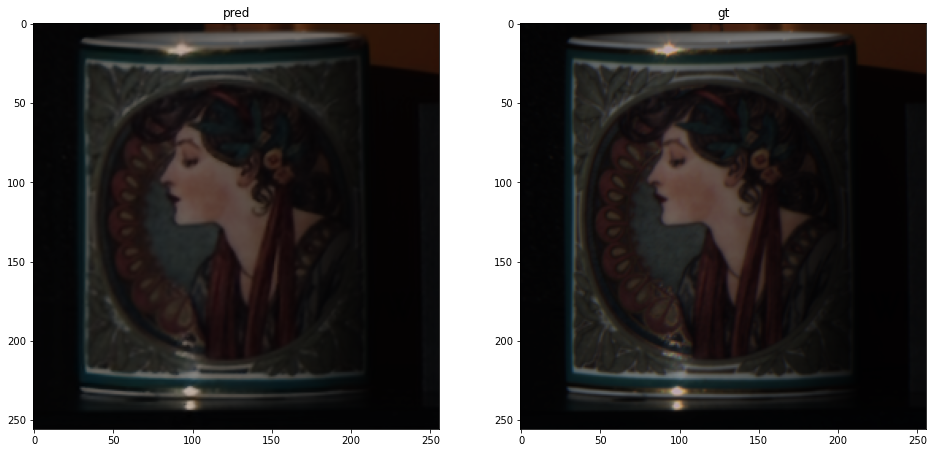

========== SAMPLE 2. PSNR: 37.05, SSIM: 0.9891 ==========


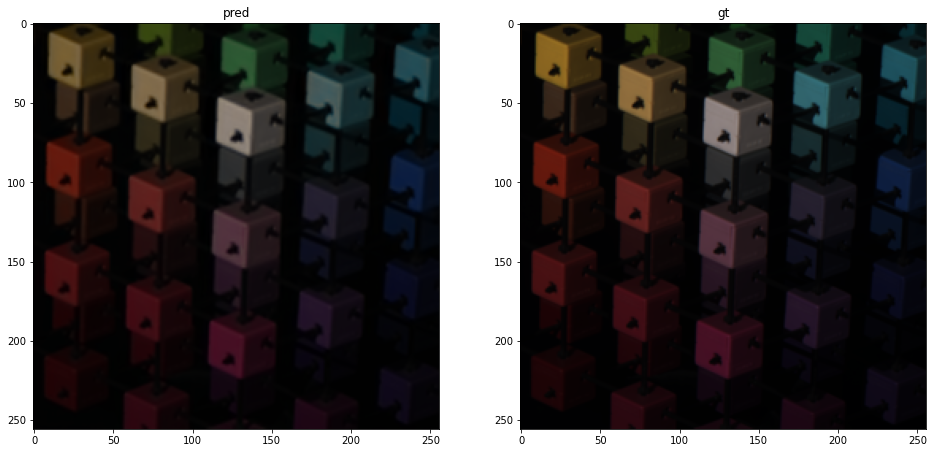

========== SAMPLE 3. PSNR: 36.63, SSIM: 0.9855 ==========


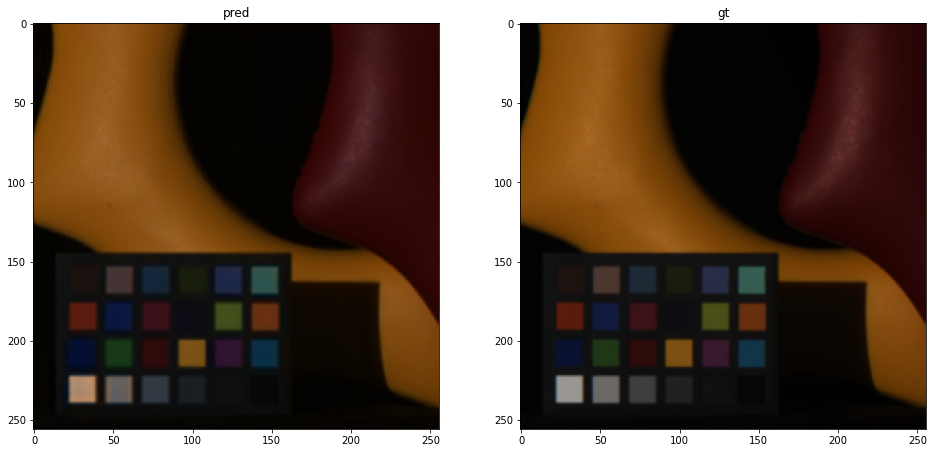

========== SAMPLE 4. PSNR: 41.62, SSIM: 0.9933 ==========


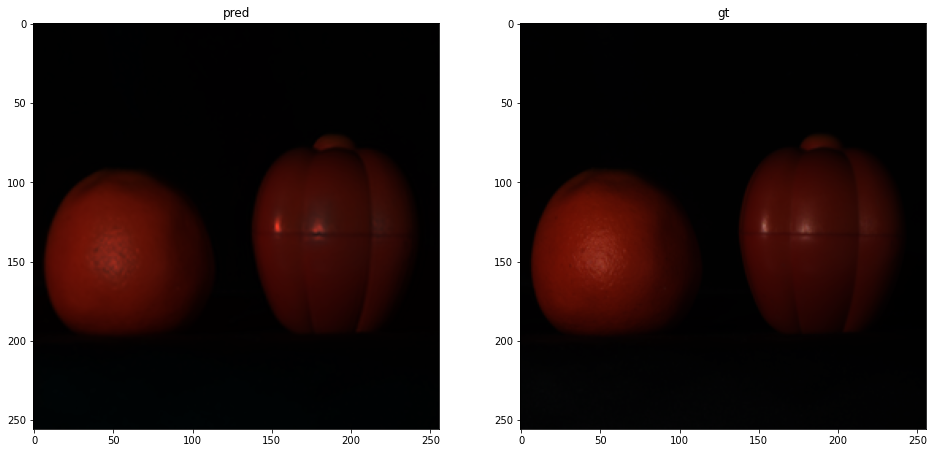

========== SAMPLE 5. PSNR: 38.86, SSIM: 0.9864 ==========


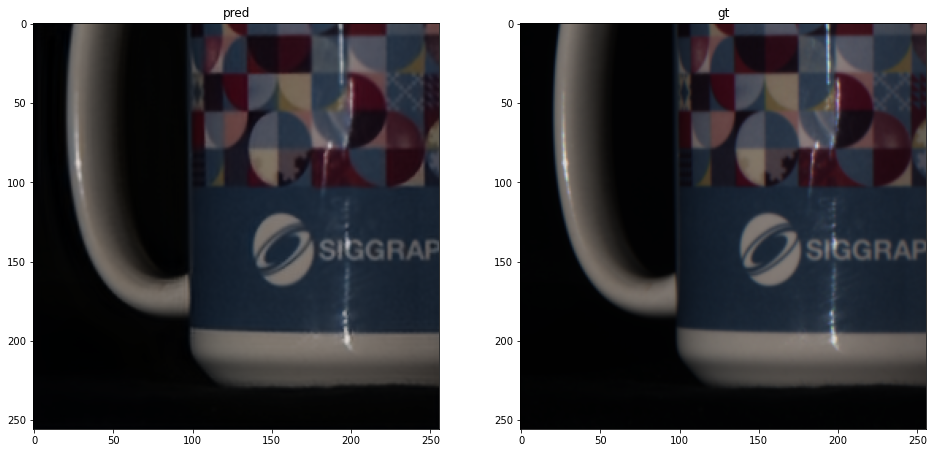

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


========== SAMPLE 6. PSNR: 37.43, SSIM: 0.9856 ==========


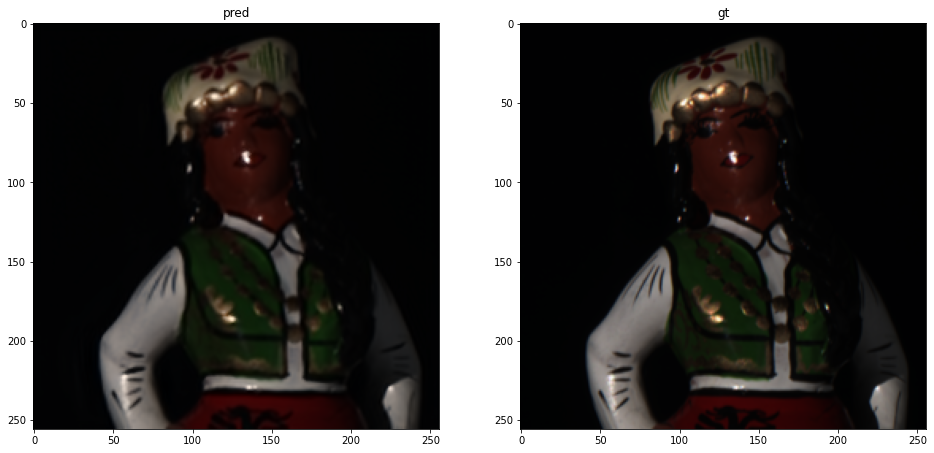

========== SAMPLE 7. PSNR: 36.54, SSIM: 0.9873 ==========


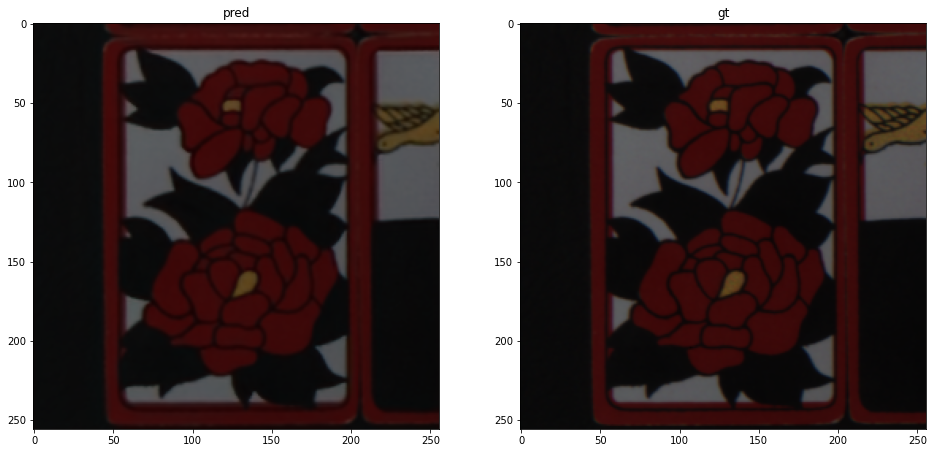

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


========== SAMPLE 8. PSNR: 34.51, SSIM: 0.9818 ==========


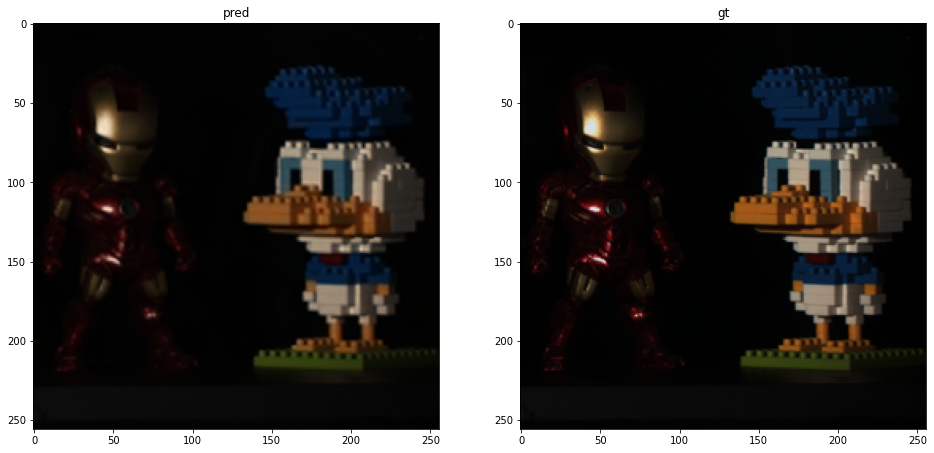

========== SAMPLE 9. PSNR: 31.47, SSIM: 0.9693 ==========


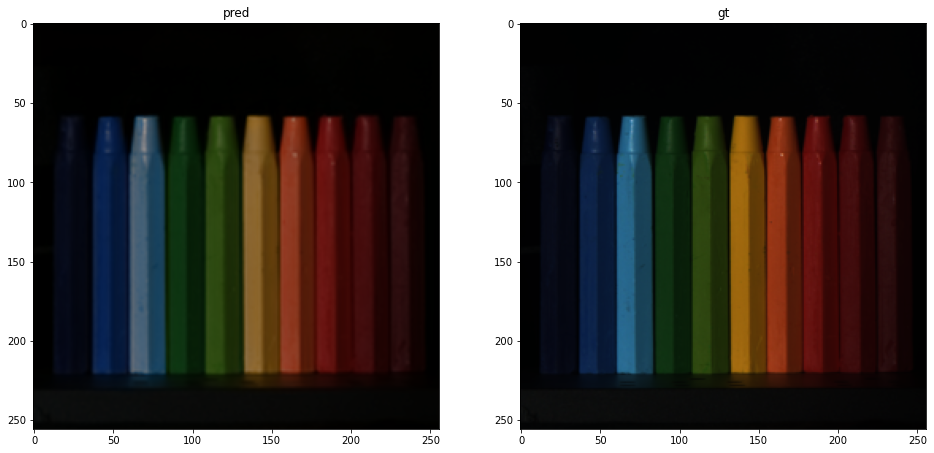

========== SAMPLE 10. PSNR: 35.05, SSIM: 0.9792 ==========


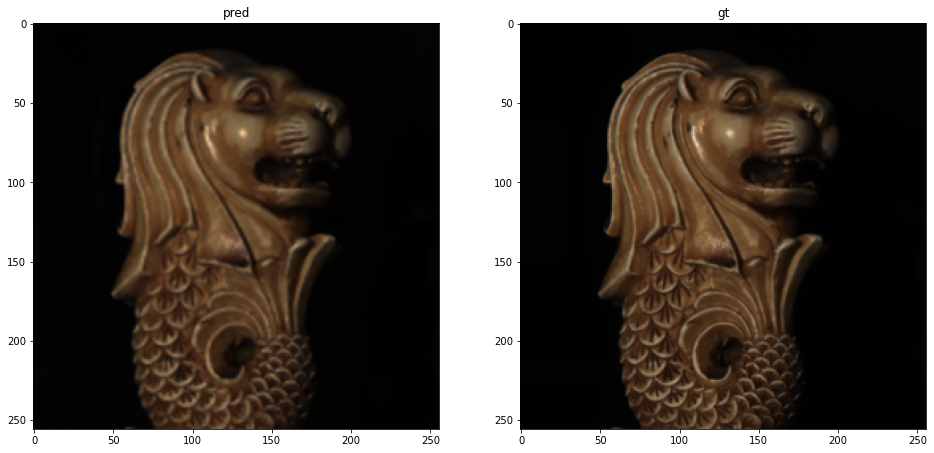

Average PSNR: 36.88. Average SSIM: 0.9846


In [7]:
# demostrate results
show_single_channels = False
psnr_list = []
ssim_list = []
for a, pred, gt in zip(range(len(pred_list)), pred_list, gt_list):
    psnr = peak_signal_noise_ratio(gt.astype(float), pred.astype(float), data_range=1.0)
    ssim = structural_similarity(  gt.astype(float), pred.astype(float), data_range=1.0)
#     ssim = structural_similarity(gt.astype(float), pred.astype(float), data_range=1.0,
#                                  channel_axis=-1, gaussian_weights=True, 
#                                  sigma=1.5, use_sample_covariance=False)
    psnr_list.append(psnr)
    ssim_list.append(ssim)
    print("========== SAMPLE {}. PSNR: {:.2f}, SSIM: {:.4f} ==========".format(a+1, psnr, ssim))
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    for ax, img, label in zip(axes.flatten(), (pred, gt), ('pred', 'gt')):
        h, w, _ = img.shape
        # the channels seems to be from short wave to long wave
        ax.imshow(img.reshape(h, w, 3, 3).mean(axis=-1)[...,::-1], vmin=0, vmax=1)
        ax.set_title(label)
    plt.show()

    if show_single_channels:
        fig, axes = plt.subplots(9, 2, figsize=(12, 54))
        for axrow, outc, gtc in zip(axes, pred.transpose(2,0,1), gt.transpose(2,0,1)):
            vmax = max(outc.max(), gtc.max())
            axrow[0].imshow(outc, vmin=0, vmax=vmax)
            axrow[1].imshow(gtc, vmin=0, vmax=vmax)
        plt.show()
        
avg_psnr = np.mean(psnr_list)
avg_ssim = np.mean(ssim_list)
print("Average PSNR: {:.2f}. Average SSIM: {:.4f}".format(avg_psnr, avg_ssim))

In [8]:
# save results
subfolder = os.path.join("../results", "hyperspec")
if not os.path.exists(subfolder):
    os.mkdir(subfolder)
sio.savemat(os.path.join(subfolder, 'pat_results.mat'), 
            {'gt': np.array(gt_list), 'pred': np.array(pred_list)})